## IRIS Task

In [30]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
setosaTrainingVec = []
versicolorTrainingVec = []
virginicaTrainingVec = []

setosaTestVec = []
versicolorTestVec = []
virginicaTestVec = []

TrainingSize = 30
TestSize = 20

with open('iris_data/class_1', 'r') as file:
    for line in file:
        if len(setosaTrainingVec) < TrainingSize:
            setosaTrainingVec.append([float(x) for x in line.split(',')])
        else:
            setosaTestVec.append([float(x) for x in line.split(',')])

with open('iris_data/class_2', 'r') as file:
    for line in file:
        if len(versicolorTrainingVec) < TrainingSize:
            versicolorTrainingVec.append([float(x) for x in line.split(',')])
        else:
            versicolorTestVec.append([float(x) for x in line.split(',')])

with open('iris_data/class_3', 'r') as file:
    for line in file:
        if len(virginicaTrainingVec) < TrainingSize:
            virginicaTrainingVec.append([float(x) for x in line.split(',')])
        else:
            virginicaTestVec.append([float(x) for x in line.split(',')])

In [32]:
#In order to properly implement w0 we need to extend the example data with 1(vector)
ones_vector_training = np.ones((TrainingSize, 1))
ones_vector_test = np.ones((TestSize, 1))

setosaTrainingVec = np.array(setosaTrainingVec)
versicolorTrainingVec = np.array(versicolorTrainingVec)
virginicaTrainingVec = np.array(virginicaTrainingVec)

# adding ones to training set
setosaTrainingVec = np.concatenate((setosaTrainingVec, ones_vector_training), axis=1)
versicolorTrainingVec = np.concatenate((versicolorTrainingVec, ones_vector_training), axis=1)
virginicaTrainingVec = np.concatenate((virginicaTrainingVec, ones_vector_training), axis=1)

setosaTestVec = np.array(setosaTestVec)
versicolorTestVec = np.array(versicolorTestVec)
virginicaTestVec = np.array(virginicaTestVec)

# adding ones to test set
setosaTestVec = np.concatenate((setosaTestVec, ones_vector_test), axis=1)
versicolorTestVec = np.concatenate((versicolorTestVec, ones_vector_test), axis=1)
virginicaTestVec = np.concatenate((virginicaTestVec, ones_vector_test), axis=1)

X = np.concatenate((setosaTrainingVec, versicolorTrainingVec, virginicaTrainingVec), axis=0)
X_test = np.concatenate((setosaTestVec, versicolorTestVec, virginicaTestVec), axis=0)

In [33]:
np.random.seed(42)

x = np.append(np.array([np.random.randint(-2,2) for i in range(4)]), 1)
W = np.random.uniform(-1, 1, (3,5)) # W is 3x4 and w0 is 3x1, together we get [W w0] -> W
T = np.concatenate((np.tile([1,0,0], (30,1)), np.tile([0,1,0], (30,1)), np.tile([0,0,1], (30,1))))

def g(x, W): # Eq 20 on vector form classification compendium
    zk = np.matmul(W, x)
    gk = 1 / (1 + np.exp(-zk))
    return gk

print(g(x, W))

[0.66583558 0.57682654 0.57587511]


In [ ]:
def MSE(X, T, W): # Eq 19 in classification compendium
    
    mseSum = 0
    for i in range(np.size(X, 0)):
        xk = X[i,:]
        tk = T[i,:]
        gk = g(xk, W)
        
        mseSum += (1/2)* np.linalg.norm((gk - tk), ord=2)
    
    return mseSum

def gradMSE(X, T, W): # Eq 22
    
    gradMSESum = np.zeros((3,5))
    
    for i in range(np.size(X, 0)):
        xk = X[i,:]
        tk = T[i,:]
        gk = g(xk, W)
        
        a = np.multiply((gk - tk), gk)
        b = np.multiply(a, np.ones(3).T - gk)

        gradMSESum += np.outer(b, xk)

    return gradMSESum

print(MSE(X, T, W))
print(gradMSE(X, T, W))
    

23.527829511996543
[[ 4.02944486e+01  1.83233122e+01  3.06259853e+01  1.01387749e+01
   6.45635849e+00]
 [ 6.64302135e+00  3.26163505e+00  4.23660367e+00  1.28989612e+00
   1.12873318e+00]
 [ 1.05749339e-03  3.42256616e-03 -3.25128108e-03 -7.10030368e-03
   1.18944957e-02]]


## Linesearch

Step lenght determined by algorithm 3.1 in Numerical Optimization by N&W, Method of training is steepest descent

In [42]:
# Backtracking linesearch algorithm 3.1

alpha0 = 0
rho = 0.9
c = 10e-4

def backtrackingLineSearch(alpha0, rho, c, Wk, pk):
    alpha = alpha0
    while MSE(X, Wk + alpha*pk, T) > MSE(X, Wk, T) + c * alpha * -pk.T * pk:
        alpha = alpha * rho
        
        if alpha > 10e-8:
            return TimeoutError
    
    return alpha
    

In [ ]:
tolerance = 1e-4
alpha = 0.05

np.random.seed(10)
W = np.random.uniform(-1, 1, (3,5))

# Condition on grad W
# while np.linalg.norm(gradMSE(X, T, W), ord='fro') > tolerance:
#     W = W - alpha * gradMSE(X, T, W)
#     print(f"Norm: {np.linalg.norm(gradMSE(X, T, W), ord='fro')}, MSE: {MSE(X, T, W)}")
    

# Condition on change in W
# W_old = W + 10*np.ones((3,5))
# while np.linalg.norm(W-W_old, ord='fro') > tolerance:
#     print(f"Change in W: {np.linalg.norm(W-W_old, ord='fro')}, MSE: {MSE(X, T, W)}")
#     W_old = W
#     W = W - alpha * gradMSE(X, T, W)

W_old = W + 10*np.ones((3,5))
# Condition on MSE
while MSE(X, T, W) > 25:
    print(f"Change in W: {np.linalg.norm(W-W_old, ord='fro')}, MSE: {MSE(X, T, W)}")
    W_old = W
    W = W - alpha * gradMSE(X, T, W)

print(MSE(X, T ,W))


Change in W: 38.72983346207417, MSE: 55.77285104417416


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 3)

# Verification of model

0 [9.87008218e-01 3.95020002e-02 5.98720513e-26]
0 [9.82111966e-01 6.60934485e-01 1.39997100e-23]
0 [9.81770686e-01 1.24045944e-01 3.38123220e-24]
0 [9.72829190e-01 1.78608857e-01 1.46009196e-22]
0 [9.85942409e-01 1.06933193e-02 5.18787645e-26]
0 [9.86033590e-01 1.40728336e-03 1.39791617e-25]
0 [9.77273742e-01 9.71428693e-03 1.59153728e-23]
0 [9.83088501e-01 6.22810005e-02 8.31676317e-25]
0 [9.69662679e-01 3.97510424e-01 9.37811499e-22]
0 [9.80480753e-01 5.08494453e-01 4.82950971e-24]
0 [9.89515790e-01 1.98833932e-02 4.73727351e-27]
0 [9.76226504e-01 2.74175417e-02 1.00103674e-23]
0 [9.80738487e-01 6.48893762e-01 6.94197760e-24]
0 [9.78846550e-01 2.22559860e-01 6.81647469e-24]
0 [9.95738239e-01 7.15729001e-03 8.98209277e-31]
0 [9.93080874e-01 4.92235310e-05 3.14395167e-29]
0 [9.91993455e-01 1.72138871e-03 1.49685959e-27]
0 [9.86642761e-01 2.81655673e-02 2.37585703e-25]
0 [9.89769005e-01 1.67595594e-02 1.05002299e-26]
0 [9.85689262e-01 1.67446173e-03 6.30682497e-26]
0 [9.85159557e-01 2.

<AxesSubplot:>

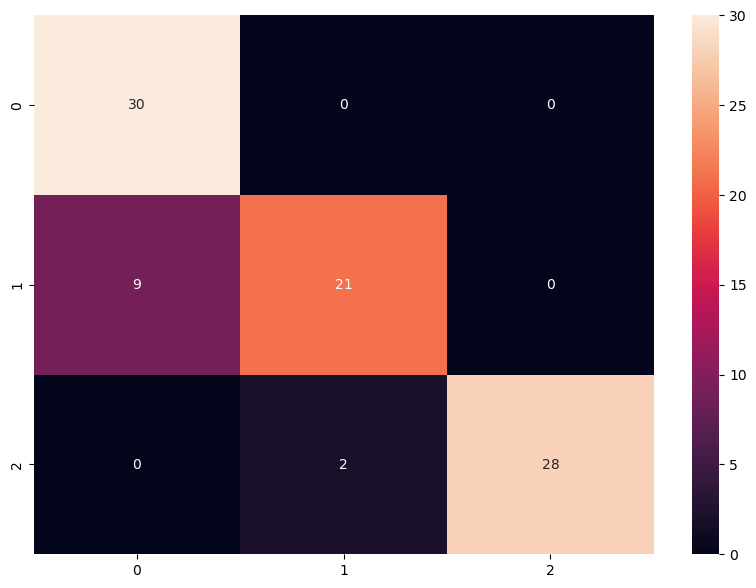

In [37]:
import seaborn as sn

T_test = np.concatenate((np.tile([1,0,0], (20,1)), np.tile([0,1,0], (20,1)), np.tile([0,0,1], (20,1))))

# x-axis: true class
# y-axis: predicted class
confMatrix = np.zeros((3,3))

for i in range(np.size(X, 0)):
    x = X[i, :]
    t = T[i, :]
    true_class = np.argmax(t)
    predicted_class = np.argmax(g(x, W))
    print(true_class, g(x, W))
    confMatrix[true_class][predicted_class] += 1

print(confMatrix)

plt.figure(figsize = (10,7))
sn.heatmap(confMatrix, annot=True)
